# Generate greedy answers
They are used to evaluate if answer is correct or incorrect. To see if an answer is correct/incorrect take fuzzy matching criterion $L(s, s') = \mathbb{1}_{\text{RougeL}(s, s') > 0.3}$ (page 7)


Structure:

```python 
{ 1131: {"greedy_answer": ..., 
         "rouge_l_score": ...
        }, 
  4295: ...
}
```
rouge_l_score stands for the Rouge-L score of the generated answer against the true answer. 

In [5]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, OPTForCausalLM, AutoModelForSequenceClassification
import yaml
import os
import pickle
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [6]:
# Load data
model_dir = config["model_dir"]
data_trivia = load_dataset("trivia_qa", "rc.nocontext")
data_trivia = data_trivia.remove_columns(["question_source", "entity_pages", "search_results"])
data_trivia_train = data_trivia["train"]
data_trivia_val = data_trivia["validation"]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
checkpoint = config["checkpoint"]
tokenizer = AutoTokenizer.from_pretrained(f"facebook/{checkpoint}", cache_dir=model_dir)
model = OPTForCausalLM.from_pretrained(f"facebook/{checkpoint}", cache_dir=model_dir)
model = model.to(device)

In [5]:
selected_training_data = data_trivia_train.select(range(0, 10))
ten_shot_prompt = ""
for data in selected_training_data:
    ten_shot_prompt += "QUESTION:" + data["question"] + "ANSWER:" + data["answer"]["value"] + "\n"

# Define stop tokens, use token on position 1 bc position 0 is special token
stop_tokens = ["Q:", "Question:", "QUESTION:", "questions:", " Q:", " Question:", " QUESTION:", " questions:",
               "A:", "Answer:", "ANSWER:", "answers:", " A:", " Answer:", " ANSWER:", " answers:", "Answers:",
               " Answers:",
               "Topic:", " Topic:", "TOPIC:", " TOPIC:", ".", " .", "...", " ...", "?", " ?", ":", " :", "!", " !"]
stop_tokens = [[tokenizer(stop_token)["input_ids"][1]] for stop_token in stop_tokens]

# Define eos token
eos_token = tokenizer("\n")["input_ids"][1]
tokenizer.pad_token_id = eos_token
tokenizer.eos_token_id = eos_token

# Maximum token length that generated answer can have
max_new_tokens = config["max_output_length"]

In [7]:
save_path = config["path_to_saved_generations"]
with open(os.path.join(save_path, "group_indices.txt"), "r") as f:
    indices_questions = {int(i) for line in f for i in line.strip().split(",")}

In [7]:
# https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-l
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

In [25]:
if os.path.exists(os.path.join(save_path, "greedy_answers.pkl")):
    with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
        result = pickle.load(f)
else:
    result = dict()

for idx in tqdm(indices_questions):
    if idx in result:
        print(f"Question {idx} already exists. Skipping...")

    result_question = dict()
    question = ten_shot_prompt + "QUESTION:" + data_trivia_val[idx]["question"] + "ANSWER:"
    answer = data_trivia_val[idx]["answer"]["value"]

    inputs = tokenizer(question, padding=False, truncation=False, return_tensors="pt").to(device)
    length_input = inputs["input_ids"].shape[1]

    # Generate sequence by always taking token with max probability (greedy)
    output_generate = model.generate(inputs.input_ids,
                                     max_new_tokens=max_new_tokens,
                                     eos_token_id=eos_token,
                                     bad_words_ids=stop_tokens)

    output = tokenizer.batch_decode(output_generate[0][length_input:], skip_special_tokens=True)
    output = "".join(output).replace("\n", "")
    result_question["greedy_answer"] = output
    rouge_l_score = scorer.score(answer, output)["rougeL"].fmeasure
    result_question["rouge_l_score"] = rouge_l_score
    result[idx] = result_question

    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(result, f)

100%|██████████| 4484/4484 [14:25<00:00,  5.18it/s]


## Analyze Rouge-L-Score

In [8]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers = pickle.load(f)

greedy_answers = pd.DataFrame.from_dict(greedy_answers, orient="index")
greedy_answers.index.name = "question_id"
greedy_answers.reset_index(inplace=True)

# Add question and true answers to df
greedy_answers["question"] = greedy_answers["question_id"].apply(lambda idx: data_trivia_val[idx]["question"])
greedy_answers["true_answer"] = greedy_answers["question_id"].apply(lambda idx: data_trivia_val[idx]["answer"]["value"])

The distribution of ROUGE-L scores across the generated answers, can be seen in this plot:

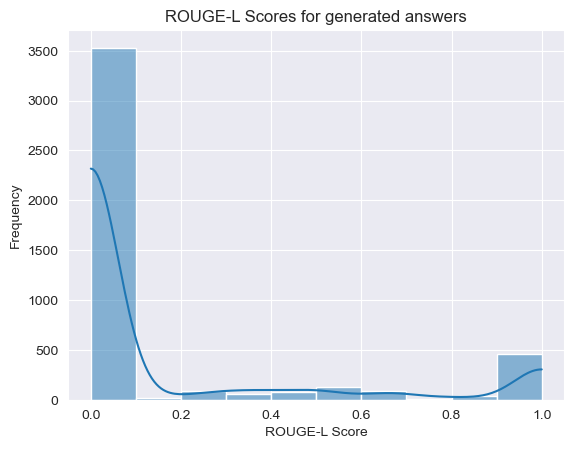

In [9]:
# Plot distribution
sns.histplot(greedy_answers["rouge_l_score"], bins=10, kde=True)
plt.title("ROUGE-L Scores for generated answers")
plt.xlabel("ROUGE-L Score")
plt.ylabel("Frequency")
plt.show()

ROUGE-L Score is based on the length of the longest common subsequence
- If score is 1 --> Perfect score --> One can be sure that answer is correct
- In the paper, it is stated that if the ROUGE-L Score is > 0.3 an answer is seen as correct. 

In [10]:
answers_exact_match = greedy_answers[greedy_answers["rouge_l_score"] == 1]
print(f"There are {len(answers_exact_match)} answers that are the exact same as the reference answer. Examples:")
answers_exact_match.head(3)

There are 462 answers that are the exact same as the reference answer. Examples:


,question_id,greedy_answer,rouge_l_score,question,true_answer
4,8196,Magma,1.0,"What name is given to the hot, molten rock fou...",MAGMA
17,8216,Dar es Salaam,1.0,What was the capital city of Tanzania until 1974?,DAR-ES-SALAAM
20,16413,Family Guy,1.0,The father of three 'Peter Griffin' is the tit...,'FAMILY GUY'


When evaluating the samples with a ROUGE-L score < 1, saying that the answer is correct if the ROUGE-L score is > 0.3 seems to be a good measure for the majority of samples, there are however cases that would get misclassified.

**Examples of False negatives:**

In [11]:
greedy_answers.loc[greedy_answers["question_id"].isin([129, 16742, 4482, 7061])]

,question_id,greedy_answer,rouge_l_score,question,true_answer
100,129,basketball,0.000000,The Naismith Award is presented in which sport?,Basket ball
257,16742,The olfactory bulb is located in the nose,0.222222,Where in the human body can you find the 'Olfa...,NOSE
2670,4482,On the bottom of the foot,0.285714,Where would you find the metatarsal bone?,Foot
3933,7061,"Jimmi Hendrix was 27, Janis Joplin was 27 and ...",0.142857,"How old were Jimmi Hendrix, Janis Joplin and J...",27


**Examples of False positives:**

There are more false positives, often due to stop words like "and" or common first names.

In [12]:
greedy_answers.loc[greedy_answers["question_id"].isin([16458, 132, 321, 8585, 8630, 4421])]


,question_id,greedy_answer,rouge_l_score,question,true_answer
57,16458,Paul Gallen,0.500000,Who is the only Rugby League player to win two...,Paul Wellens
106,132,The Graduate,0.333333,What was Warren Beatty's first movie?,Splendor in the Grass
235,321,The Grapes,0.400000,What is the most common pub name in the UK?,The Red Lion
290,8585,St Thomas',0.400000,"Rahere, an Anglo-Norman monk, founded which Lo...",St Bartholomew's
329,8630,The Graduate,0.500000,For which 1960 film did Billy Wilder become th...,The Apartment
2640,4421,The Australian Open,0.666667,What is the last Grand Slam tennis tournament ...,The US Open


On page 17, they show that the choice of accuracy metric has almost no effect on the measured AUROC of the uncertainty estimation when using TriviaQA. To reproduce this results, I also calculate the Rouge-1 measure:

In [70]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

In [71]:
scorer = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)

In [72]:
for idx in greedy_answers_infer.keys():
    answer = data_trivia_val[idx]["answer"]["value"]
    generated_answer = greedy_answers_infer[idx]["greedy_answer"]
    rouge_1_score = scorer.score(answer, generated_answer)["rouge1"].fmeasure
    greedy_answers_infer[idx]["rouge_1_score"] = rouge_1_score

    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(greedy_answers_infer, f)

However, note that there are only a few cases where ROUGE-1 != ROUGE-L:

In [37]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

n_cases = 0
for i in greedy_answers_infer:
    if greedy_answers_infer[i]["rouge_l_score"] != greedy_answers_infer[i]["rouge_1_score"]:
        n_cases += 1
print(f"Number of cases: {n_cases}")

Number of cases: 9


## Manually label by hand
To account for FP and FN, I also label the generated questions by hand to be able to then compare the results to the ROUGE metrics:

In [120]:
with open(os.path.join(save_path, "greedy_answers.pkl"), "rb") as f:
    greedy_answers_infer = pickle.load(f)

In [121]:
# variable input used
if "input" in globals():
    del input
    
for idx in greedy_answers_infer.keys():
    if "label_by_hand" in greedy_answers_infer[idx]:
        print(f"{idx} already exists. Skipping...")
        continue
    
    question = data_trivia_val[idx]["question"]
    answer = data_trivia_val[idx]["answer"]["value"]
    generated_answer = greedy_answers_infer[idx]["greedy_answer"]
    so_far = greedy_answers_infer[idx]["rouge_l_score"] > 0.5
    
    # Print the question, answer, and generated answer
    print(f"Question: {question}")
    print(f"Answer: {answer}")
    print(f"Generated Answer: {generated_answer}")
    
    # Prompt the user for input
    user_input = False
    while user_input not in ["", "1", "0"]:
        user_input = input(f"{idx}) {question}\n{answer}\n{generated_answer}\nSo far: {so_far}\nCorrect? (then input nothing), otherwise 1 for true, 0 for false: ")
    
    # Save the input as 1 (true) or 0 (false)
    label_by_hand = so_far if user_input == "" else int(user_input)
    greedy_answers_infer[idx]["label_by_hand"] = label_by_hand
    
    print()
    # Save new dictionary
    with open(os.path.join(save_path, "greedy_answers.pkl"), "wb") as f:
        pickle.dump(greedy_answers_infer, f)

0 already exists. Skipping...
8192 already exists. Skipping...
2 already exists. Skipping...
16386 already exists. Skipping...
8196 already exists. Skipping...
5 already exists. Skipping...
8199 already exists. Skipping...
9 already exists. Skipping...
8204 already exists. Skipping...
16397 already exists. Skipping...
8207 already exists. Skipping...
16400 already exists. Skipping...
17 already exists. Skipping...
8209 already exists. Skipping...
8212 already exists. Skipping...
16404 already exists. Skipping...
23 already exists. Skipping...
8216 already exists. Skipping...
25 already exists. Skipping...
16410 already exists. Skipping...
16413 already exists. Skipping...
30 already exists. Skipping...
8223 already exists. Skipping...
16416 already exists. Skipping...
8225 already exists. Skipping...
8226 already exists. Skipping...
8227 already exists. Skipping...
16420 already exists. Skipping...
16414 already exists. Skipping...
16423 already exists. Skipping...
45 already exists. S